# Text Augmentation

\
Data augmentation techniques are used to generate additional, synthetic data using the data you have.

\
Image augmentation has become a standard proceducre in computer vision applications but text augmentation is relatively new to natural language processing (NLP) field.

\
The [nlpaug](https://github.com/makcedward/nlpaug) module implements a number of high-performance text augmentation algorithms that may boost performance of NLP models.

\
In Part 1 of the tutorial, we introduced some cool text augmentation functions in the nlpaug module.

\
In Part 2 of the tutorial, we used the nlpaug module to generate text augmentations to Twitter tweet data and evaluate bag-of-words model performances with and without text augmentations.


\
In this Part 3 of the tutorial, we will use the nlpaug module to generate text augmentations to Twitter tweet data and evaluate **deep neural network** model performances with and without text augmentations.

\
References and recommended readings:
* [nlpaug Git Hub site](https://github.com/makcedward/nlpaug)
* [Data Augmentation in NLP: Introduction to Text Augmentation](https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28)

## Install and import modules

In [1]:
# Install the most recent version of gensim.
# Otherwise, you may get the following error when running naw.WordEmbsAug():
# 'Word2VecKeyedVectors' object has no attribute 'index_to_key'
# see: https://stackoverflow.com/questions/71032760/word2veckeyedvectors-object-has-no-attribute-index-to-key
!pip install --upgrade gensim --quiet

     |████████████████████████████████| 24.1 MB 16.4 MB/s 


In [2]:
# Import gensim.
# Note: You will need to retart runtime in order to import the most recent version of gensim 
import gensim
print(gensim.__version__)

4.2.0


In [3]:
# Install the tokenizer needed by the back translation model
!pip install sacremoses --quiet

     |████████████████████████████████| 880 kB 16.0 MB/s 


In [4]:
# Install the tokenizer
import sacremoses

In [5]:
# Install the nlpaug module
!pip install nlpaug --quiet

     |████████████████████████████████| 410 kB 16.2 MB/s 


In [6]:
# Import the nlpaug module and its methods
import nlpaug.augmenter.word as naw
import nlpaug.flow as nafc
from nlpaug.util import Action

In [7]:
# Install Huggingface Transformers
! pip install transformers[sentencepiece] --quiet

     |████████████████████████████████| 4.9 MB 14.8 MB/s 
     |████████████████████████████████| 120 kB 82.5 MB/s 
     |████████████████████████████████| 6.6 MB 55.2 MB/s 
     |████████████████████████████████| 1.3 MB 74.9 MB/s 


In [8]:
# Install datasets
! pip install datasets --quiet

     |████████████████████████████████| 431 kB 14.6 MB/s 
     |████████████████████████████████| 115 kB 81.0 MB/s 
     |████████████████████████████████| 212 kB 64.6 MB/s 
     |████████████████████████████████| 127 kB 82.4 MB/s 


In [31]:
# Import other modules
import nltk 
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gc

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
# Mount Google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Twitter Climate Change Sentiment Dataset

\
[The dataset can be downloaded from Kaggle.](https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset)

\
The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo.

\
This dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were annotated. Each tweet is labelled independently by 3 reviewers. This dataset only contains tweets that all 3 reviewers agreed on (the rest were discarded).

\
Each tweet is labelled as one of the following classes:
* 2 (News): the tweet links to factual news about climate change
* 1 (Pro): the tweet supports the belief of man-made climate change
* 0 (Neutral): the tweet neither supports nor refutes the belief of man-made climate change
* -1 (Anti): the tweet does not believe in man-made climate change

In [11]:
# Read in the dataset using Pandas (for the purpose of train/val/test split before coverting to Datasets)
path = '/content/drive/MyDrive/Deep Learning Course/Datasets'
df = pd.read_csv(os.path.join(path, "twitter_sentiment_data.csv"))

# Rename column names and remove the tweetid column
df = df.rename(columns = {"sentiment": "label", "message": "text"}).drop('tweetid', axis = 1)

In [12]:
# Recode the labels to 0, 1, 2, and 3
# 0 - negative; 1 - neutral; 2 - positive; 3 - news 
# IMPORTANT NOTE: The huggingface model classification head assumes the classes to be continuously labeled
# from 0, e.g., 0, 1, 2, 3; so that we will have to relabel the orginal classes that way. Otherwise the
# model training will crash. For example, if we have classes like 1, 2, 3, and 4, the model will assume that 
# we have 5 classes in total (automatically adding 0 to the classes), which will mess up the training. 
df['label'] = df['label'].replace([-1, 0, 1, 2],[0, 1, 2, 3])

In [13]:
# Important Note: Check the integrity of the DataFrame to ensure that there are no missing values, 
# which will deter the training progress. Here, we simply drop any missing observations.
df = df.dropna()

In [14]:
# Split the data into 80% train, 10% validation, and 10% test using sklearn
from sklearn.model_selection import train_test_split
train_df, valtest_df = train_test_split(df, test_size = 0.2, random_state = 42)
val_df, test_df = train_test_split(valtest_df, test_size = 0.5, random_state = 42)
train_df.shape, val_df.shape, test_df.shape

((35154, 2), (4394, 2), (4395, 2))

In [15]:
# Convert the three DataFrames to three Datasets (Aparche Arrow format)
dset_train = Dataset.from_pandas(train_df)
dset_val = Dataset.from_pandas(val_df)
dset_test = Dataset.from_pandas(test_df)

In [16]:
# Gather train, val, and test Datasets to have a single DatasetDict, which can be manipulated together
tweets = DatasetDict({
  'train': dset_train,
  'val': dset_val,
  'test': dset_test})
# Dataset.from_pandas will add an index column, which can be removed
tweets = tweets.remove_columns(["__index_level_0__"])

In [54]:
# Show the DatasetDict object, which contains three Datasets
tweets

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 35154
    })
    val: Dataset({
        features: ['label', 'text'],
        num_rows: 4394
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 4395
    })
})

In [18]:
# Specify the model checkpoint
# Note: Find pre-trained models that support AutoModelForSequenceClassification:
# https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification
model_ckpt = "distilbert-base-uncased"

# Load the tokenizer from the pretrained model
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Tokenizing the Whole Dataset

To tokenize the whole corpus, we’ll use the map() method of our DatasetDict object. It provides a convenient way to apply a processing function to each element in a dataset.

In [19]:
# Define a processing function to tokenize a batch of examples
def tokenize(batch):
  return tokenizer(
    batch["text"], 
    # Pad the examples with zeros to the size of the longest one in a batch
    padding = True, 
    # Truncate the examples to the model’s maximum context size (which is 512 for this model)
    truncation = True)

In [20]:
# Once we’ve defined a processing function, we can apply it across all the splits in the DataDict.
tweets_encoded = tweets.map(
  tokenize, 
  # Encode the tweets in batches
  batched = True, 
  # Apply the tokenize function on the full dataset as a single batch
  # Note: This ensures that the input tensors and attention masks have the same shape globally
  # Alternatively, we can specify max_length in the tokenize() function to ensure the same
  batch_size = None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
# Take a look the the processed Dataset
# Note: two new columns 'input_ids' and 'attention_mask' are added.
tweets_encoded

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 35154
    })
    val: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 4394
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 4395
    })
})

In [22]:
# Remove the text column from the encoded DatasetDict because the model does not use it.
tweets_encoded = tweets_encoded.remove_columns(['text'])

# Since the model expects tensors as inputs, 
# we will convert the input_ids and attention_mask columns to the "torch" format.
tweets_encoded.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

### Loading a pretrained model

* The first thing we need is a pretrained DistilBERT model. We use the AutoModelForSequenceClassification model instead of AutoModel in the Hugging Face Transformers.

\
* The difference is that the AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model.

\
* We just need to specify how many labels the model has to predict (four in our case), since this dictates the number of outputs the classification head has.

In [23]:
# Use GPU (cuda) if available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# Define two dictionaries that convert between ids (0, 1, 2, 3) and labels (strings)
# Note: By adding label2id and id2label to our model's config, 
# we will get friendlier labels in the inference API.
label2id = {}
id2label = {}
labels = ['anti', 'neutral', 'pro', 'news']
for i, label_name in enumerate(labels):
  label2id[label_name] = str(i)
  id2label[str(i)] = label_name

# Take a look the two dictionaries
label2id, id2label, len(label2id)

({'anti': '0', 'neutral': '1', 'pro': '2', 'news': '3'},
 {'0': 'anti', '1': 'neutral', '2': 'pro', '3': 'news'},
 4)

In [25]:
# Grab the pre-trained model with a classification head
model = AutoModelForSequenceClassification.from_pretrained(
  # The pretrained model
  model_ckpt, 
  # Number of classes/labels
  num_labels = len(label2id),
  # A dictionary linking label to id
  label2id = label2id,
  # A dictionary linking id to label
  id2label = id2label).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

### Define the performance metrics

* To monitor metrics during training, we need to define a compute_metrics() function for the Trainer.

* For our application, we’ll compute the F1-score and the accuracy of the model.

In [27]:
# Define a function to compute two metrics--accuracy and f1 score
def compute_metrics(pred):
  # True labels
  labels = pred.label_ids
  # Predicted labels
  # Note: argmax(-1) will get the index/label_id correponding to the largest value in `predictions`
  preds = pred.predictions.argmax(-1)
  # Note: average = "weighted" will weigh the f1_score by class sample size
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  # Note: Need to return a dictionary
  return {"accuracy": acc, "f1": f1}

### Train the model

To define the training parameters, we use the `TrainingArguments` class. This class stores a lot of information and gives you fine-grained control over the training and evaluation. The most important argument to specify is `output_dir`, which is where all the artifacts from training are stored.

In [55]:
## Define the training arguments

# Batch size
batch_size = 8

# Number of epochs
num_epochs = 3

# Name of the model (to be uploaded to Huggingface)
model_name = f"{model_ckpt}-finetuned-climate-change"

# Specify the path to store the fine-tuned model
path_model = '/content/drive/MyDrive/Deep Learning Course/Models'

# Training argument
training_args = TrainingArguments(
  # Output directory
  # Note: All model checkpoints will be saved to the folder named `model_name`
  output_dir = os.path.join(path_model, model_name),
  # Number of epochs
  num_train_epochs = num_epochs,
  # Learning rate
  learning_rate = 2e-5,
  # Batch size for training and validation
  per_device_train_batch_size = batch_size,
  per_device_eval_batch_size = batch_size,
  # Weight decay for regularization
  weight_decay = 0.01,
  # Validate the model using the val set after each epoch
  evaluation_strategy = "epoch",
  # Load the best model at the end of training
  load_best_model_at_end = True,
  # Push to Huggingface Hub
  # It could be helpful to push the model to the Hub for sharing and using pipeline(), but
  # it takes a very long time to push the model, so we choose not do it here.
  push_to_hub = False,
  # Save model checkpoint after each epoch
  save_strategy = "epoch")

In [ ]:
# Define the trainer
trainer = Trainer(
  # Model
  model = model, 
  # Training argument
  args = training_args,
  # Metrics (f1 score and accuracy)
  compute_metrics = compute_metrics,
  # Train and val Datasets
  train_dataset = tweets_encoded["train"],
  eval_dataset = tweets_encoded["val"],
  # Tokenizer
  tokenizer = tokenizer)

In [56]:
# Clean up the memory using the garbage cleaner
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Start the training process
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 35154
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1650


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.796300,0.652997,0.744424,0.729541
2,0.583900,0.588057,0.771051,0.764478
3,0.483400,0.585688,0.773555,0.767816


***** Running Evaluation *****
  Num examples = 4394
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-550
Configuration saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-550/config.json
Model weights saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-550/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-550/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-550/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4394
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/Deep Learning Course/Mod

TrainOutput(global_step=1650, training_loss=0.6067546405214251, metrics={'train_runtime': 1411.9669, 'train_samples_per_second': 74.692, 'train_steps_per_second': 1.169, 'total_flos': 7394687589672432.0, 'train_loss': 0.6067546405214251, 'epoch': 3.0})

In [ ]:
# We can take a more detailed look at the training metrics by calculating the confusion matrix. 
# To visualize the confusion matrix, we first need to get the predictions on the validation set. 
# The predict() method of the Trainer class returns several useful objects we can use for evaluation.
preds_output = trainer.predict(tweets_encoded["val"])

***** Running Prediction *****
  Num examples = 4394
  Batch size = 64


In [ ]:
# The output of the predict() method is a PredictionOutput object that contains 
# arrays of predictions and label_ids, along with the metrics we passed to the trainer. 
# For example, the metrics on the validation set can be accessed.
preds_output.metrics

{'test_accuracy': 0.7735548475193446,
 'test_f1': 0.767816193926339,
 'test_loss': 0.585688054561615,
 'test_runtime': 7.6143,
 'test_samples_per_second': 577.072,
 'test_steps_per_second': 9.062}

In [ ]:
# It also contains the raw predictions for each class. 
# We can decode the predictions using np.argmax().
y_preds = np.argmax(preds_output.predictions, axis = 1)

Text(0.5, 1.0, 'Normalized confusion matrix')

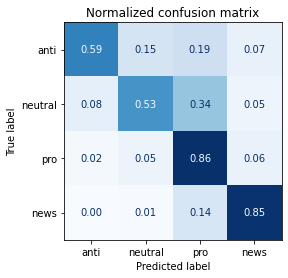

In [ ]:
# With the predictions, we can plot the confusion matrix.
cm = confusion_matrix(tweets_encoded["val"]['label'], y_preds, normalize = "true")
labels = ['anti', 'neutral', 'pro', 'news']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = "Blues", values_format = ".2f", colorbar = False)
plt.title("Normalized confusion matrix")

In [ ]:
# Model prediction metrics on the test set
preds_output = trainer.predict(tweets_encoded["test"])
preds_output.metrics

***** Running Prediction *****
  Num examples = 4395
  Batch size = 64


{'test_accuracy': 0.7781569965870307,
 'test_f1': 0.7714920434332613,
 'test_loss': 0.5882534980773926,
 'test_runtime': 6.9357,
 'test_samples_per_second': 633.678,
 'test_steps_per_second': 9.949}

### Save and share the model

In [ ]:
# Since we specified the option "load_best_model_at_end = True" in the training argument,
# the current model is the best one. We now want to save the model locally.
# Note: We can still use the pre-trained model's tokenizer since we did not modify it,
# but for illustration purpose, we save the tokenizer as well.
model.save_pretrained(
  os.path.join(path_model, 'distilbert-base-uncased-finetuned-tweets-climate-change'))
tokenizer.save_pretrained(
    os.path.join(path_model, 'distilbert-base-uncased-finetuned-tweets-climate-change'))

Configuration saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-tweets-climate-change/config.json
Model weights saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-tweets-climate-change/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-tweets-climate-change/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-tweets-climate-change/special_tokens_map.json


('/content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-tweets-climate-change/tokenizer_config.json',
 '/content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-tweets-climate-change/special_tokens_map.json',
 '/content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-tweets-climate-change/vocab.txt',
 '/content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-tweets-climate-change/added_tokens.json',
 '/content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-tweets-climate-change/tokenizer.json')

In [ ]:
# Because we choose not to push our model to the Hub, we will load the locally-saved best model here.
from transformers import pipeline
classifier = pipeline(
  "text-classification", 
  model = os.path.join(path_model, 'distilbert-base-uncased-finetuned-tweets-climate-change'),
  tokenizer = os.path.join(path_model, 'distilbert-base-uncased-finetuned-tweets-climate-change'))

loading configuration file /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-tweets-climate-change/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-tweets-climate-change",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "anti",
    "1": "neutral",
    "2": "pro",
    "3": "news"
  },
  "initializer_range": 0.02,
  "label2id": {
    "anti": "0",
    "neutral": "1",
    "news": "3",
    "pro": "2"
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "tra

In [ ]:
# Then we can test the pipeline with a sample tweet (or a tweet from our test set).
custom_tweet = "Stop dumping trash and save our ocean!"
preds = classifier(custom_tweet, return_all_scores = True)
preds

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


[{'label': 'anti', 'score': 0.01849079132080078},
 {'label': 'neutral', 'score': 0.05884091556072235},
 {'label': 'pro', 'score': 0.9187394976615906},
 {'label': 'news', 'score': 0.003928736783564091}]

In [ ]:
# Let's test another tweet
custom_tweet = "Global warming is a fake claim made by some crazy scientists!"
preds = classifier(custom_tweet)
preds

[{'label': 'anti', 'score': 0.7717410922050476}]

### Initiate three alternative text augmentation strategies

In [57]:
# Initiate the synonym augmentation 
aug_syn = naw.SynonymAug(
  aug_src = 'wordnet',
  aug_max = 3)

In [58]:
## Initiate the contextual word embeddings (BERT, DistilBERT, RoBERTA or XLNet) augmentation 
aug_emb = naw.ContextualWordEmbsAug(
  # Other models include 'distilbert-base-uncased', 'roberta-base', etc.
  model_path = 'distilbert-base-uncased', 
  # You can also choose "insert"
  action = "substitute",
  # Use GPU
  device = 'cuda'
  )

In [59]:
# Initiate the back translation augmentation
aug_bt = naw.BackTranslationAug(
  # Translate English to German
  from_model_name = 'facebook/wmt19-en-de', 
  # Translate German back to English
  to_model_name = 'facebook/wmt19-de-en',
  # Use GPU
  device = 'cuda')

In [75]:
# Create a function to evaluate text augmentation on model performance on test set
def evaluate_aug(aug_strategy, n, train_df, dset_val, dset_test):

  # Create two lists to store augmented tweets and their correponding labels
  augmented_tweets = []
  augmented_tweets_labels = []

  # Loop through the train set to create augmented tweets
  # Note: We create n augmented tweets per original tweet. 
  for i in train_df.index:
    if aug_strategy == 'synonym':
      lst_augment = aug_syn.augment(train_df['text'].loc[i], n = n)
    elif aug_strategy == 'embedding':
      lst_augment = aug_emb.augment(train_df['text'].loc[i], n = n)
    else:
      lst_augment = aug_bt.augment(train_df['text'].loc[i], n = n)
    for augment in lst_augment:
      augmented_tweets.append(augment)
      augmented_tweets_labels.append(train_df['label'].loc[i])

  # Zip the two lists into a list of tuples
  augmented_tweets_labels = list(zip(augmented_tweets, augmented_tweets_labels))

  # Convert the list of tuples to a Pandas Dataframe.
  df_augmented_tweets_labels = pd.DataFrame(
    augmented_tweets_labels, columns = ['text', 'label'])
  
  # Vertically concat the train set with the augmented texts
  train_df_augmented = pd.concat([train_df, df_augmented_tweets_labels], axis = 0)

  # Convert the DataFrame to a Dataset (Aparche Arrow format)
  dset_train_augmented = Dataset.from_pandas(train_df_augmented)

  # Gather train, val, and test Datasets to have a single DatasetDict, 
  # which can be manipulated together
  tweets_augmented = DatasetDict({
    'train': dset_train_augmented,
    'val': dset_val,
    'test': dset_test})
  tweets_augmented = tweets_augmented.remove_columns(["__index_level_0__"])

  # Tokenize the tweets dataset
  tweets_augmented_encoded = tweets_augmented.map(
    tokenize, 
    batched = True, 
    batch_size = None)
  
  # Remove the text column from the encoded DatasetDict because the model does not use it.
  tweets_augmented_encoded = tweets_augmented_encoded.remove_columns(['text'])

  # Since the model expects tensors as inputs, 
  # we will convert the input_ids and attention_mask columns to the "torch" format.
  tweets_augmented_encoded.set_format(
    "torch", columns = ["input_ids", "attention_mask", "label"])
  
  # Define the trainer
  trainer = Trainer(
    # Model
    model = model, 
    # Training argument
    args = training_args,
    # Metrics (f1 score and accuracy)
    compute_metrics = compute_metrics,
    # Train and val Datasets
    train_dataset = tweets_augmented_encoded["train"],
    eval_dataset = tweets_augmented_encoded["val"],
    # Tokenizer
    tokenizer = tokenizer)
  
  # Clean up the memory using the garbage cleaner
  gc.collect()
  torch.cuda.empty_cache()

  # Start the training process
  trainer.train()

  # Use the model to predict the test set
  preds_output = trainer.predict(tweets_encoded["test"])
  print(preds_output.metrics)

  # Remove all elements from the lists
  augmented_tweets.clear()
  augmented_tweets_labels.clear()

In [76]:
# Evaluate the synonym text augmentation
score_synonym = evaluate_aug(
  aug_strategy = 'synonym', 
  n = 1, 
  train_df = train_df,
  dset_val = dset_val, 
  dset_test = dset_test)
print(score_synonym)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 70308
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26367
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.479100,0.587340,0.788348,0.784972
2,0.275400,0.972060,0.780838,0.778443
3,0.135600,1.364257,0.784934,0.780465


***** Running Evaluation *****
  Num examples = 4394
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-8789
Configuration saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-8789/config.json
tokenizer config file saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-8789/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-8789/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4394
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-17578
Configuration saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert

{'test_loss': 0.588193953037262, 'test_accuracy': 0.7886234357224118, 'test_f1': 0.785102138189145, 'test_runtime': 6.0806, 'test_samples_per_second': 722.788, 'test_steps_per_second': 90.451}
None


In [77]:
# Evaluate the embedding text augmentation
score_synonym = evaluate_aug(
  aug_strategy = 'embedding', 
  n = 1, 
  train_df = train_df,
  dset_val = dset_val, 
  dset_test = dset_test)
print(score_synonym)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 70308
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26367


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.479300,0.647966,0.786982,0.782091
2,0.306900,1.008245,0.780382,0.778235
3,0.190600,1.390844,0.781065,0.777242


***** Running Evaluation *****
  Num examples = 4394
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-8789
Configuration saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-8789/config.json
tokenizer config file saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-8789/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-8789/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4394
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-17578
Configuration saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert

{'test_loss': 0.6387358903884888, 'test_accuracy': 0.7920364050056883, 'test_f1': 0.7872835823981533, 'test_runtime': 5.8725, 'test_samples_per_second': 748.407, 'test_steps_per_second': 93.657}
None


In [78]:
# Evaluate the back translation text augmentation
score_synonym = evaluate_aug(
  aug_strategy = 'backtranslation', 
  n = 1, 
  train_df = train_df,
  dset_val = dset_val, 
  dset_test = dset_test)
print(score_synonym)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 70308
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26367


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.286600,1.016802,0.781065,0.780137
2,0.147200,1.407957,0.778107,0.775744
3,0.061000,1.587856,0.788348,0.785782


***** Running Evaluation *****
  Num examples = 4394
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-8789
Configuration saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-8789/config.json
tokenizer config file saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-8789/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-8789/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4394
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/Deep Learning Course/Models/distilbert-base-uncased-finetuned-climate-change/checkpoint-17578
Configuration saved in /content/drive/MyDrive/Deep Learning Course/Models/distilbert

{'test_loss': 0.9874382019042969, 'test_accuracy': 0.7861205915813424, 'test_f1': 0.785303959584641, 'test_runtime': 6.3029, 'test_samples_per_second': 697.293, 'test_steps_per_second': 87.261}
None
